# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


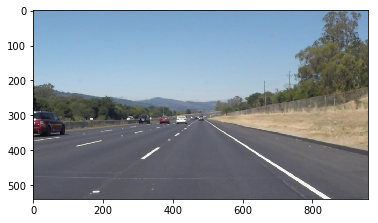

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math
from scipy.optimize import curve_fit

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return mask, masked_image


def draw_lines(img, lines, video, color=[255, 0, 0], thickness=10):
    """
    extrapolation of the line segments to map out the full extent of the lane. 
    """

    x_pos = []; y_pos = []; 
    x_neg = []; y_neg = [];
    pos_slopes = []
    neg_slopes = []
    
    max_x = int(img.shape[1])
    for line in lines:
        for x1,y1,x2,y2 in line:   
            if ((y2-y1)/(x2-x1))<0:   # and x2 < max_x/2 and x1 < max_x/2:
                x_pos.extend([x1, x2])
                y_pos.extend([y1, y2])
                pos_slopes.append((y2-y1)/(x2-x1))
            elif ((y2-y1)/(x2-x1))>0: # and x2 > max_x/2 and x1 > max_x/2:
                x_neg.extend([x1, x2])
                y_neg.extend([y1, y2])
                neg_slopes.append((y2-y1)/(x2-x1))

    #Remove slope outliers, and take the average
    pos_slopes, x_pos, y_pos = remove_outliers(pos_slopes, x_pos, y_pos)
    neg_slopes, x_neg, y_neg = remove_outliers(neg_slopes, x_neg, y_neg)
    
    # regression calculation for positive and negative slopes separately
    pos_fit = np.polyfit(x_pos, y_pos ,1)
    neg_fit = np.polyfit(x_neg, y_neg ,1)
    
    # for video: if fit is bad, then replace fit params with params from previous frame
    if video == 1:    
        fit_params = good_fit(np.append(pos_fit,neg_fit))
        pos_fit = fit_params[-1, 0:2]
        neg_fit = fit_params[-1, 2:4]
    
   
    [x1, y1, x2, y2] = line_calc(img, pos_fit, y_pos, y_neg)
    cv2.line(img, (x1, y1), (x2, y2), color, thickness)
        
    [x1, y1, x2, y2] = line_calc(img, neg_fit, y_neg, y_pos)
    cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
    
def remove_outliers(slopes, x, y, m = 1.5):
    med = np.mean(slopes)
    std = np.std(slopes)
    i = 0
    
    for slope in slopes:
        if abs(slope - med) > (m * std):
            slopes.remove(slope)
            del x[i:i+1]
            del y[i:i+1]
        else:
            i+=1
   
    return slopes, x, y


def good_fit(curr_params):
    global fit_params

    #are we here first time?
    if(len(fit_params) == 0):
        fit_params = [curr_params]
        return curr_params
    else:
        fit_params = np.concatenate([fit_params, [curr_params]], axis=0)
    
    if abs(fit_params[-2, 0] - fit_params[-1, 0]) > 0.06 :
        fit_params[-1, 0] = fit_params[-2, 0]
        
    if abs(fit_params[-2, 1] - fit_params[-1, 1]) > 30 :
        fit_params[-1, 1] = fit_params[-2, 1]
    
    if abs(fit_params[-2, 2] - fit_params[-1, 2]) > 0.06 :
        fit_params[-1, 2] = fit_params[-2, 2]

    if abs(fit_params[-2, 3] - fit_params[-1, 3]) > 30 :
        fit_params[-1, 3] = fit_params[-2, 3]   
    
    return fit_params

def line_calc(img, fit, y, y_other):
    slope = fit[0]
    intersect = fit[1]
    
    y1 = int(img.shape[0])
    x1 = int((y1-intersect)/slope)
    y2 = min(min(y), min(y_other))
    x2 = int((y2-intersect)/slope)
    
    return x1, y1, x2, y2
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, video):
    #`img` should be the output of a Canny transform
    # Returns an image with hough lines drawn.
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    draw_lines(line_img, lines, video)
    return line_img


def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):

    return cv2.addWeighted(initial_img, α, img, β, λ)


## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
images = os.listdir("test_images/")

run your solution on all test_images and make copies into the test_images directory).

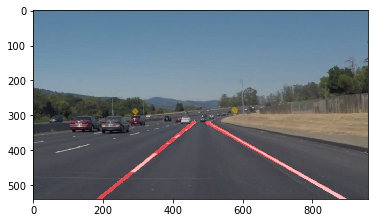

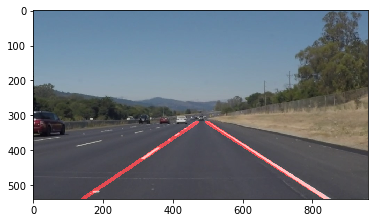

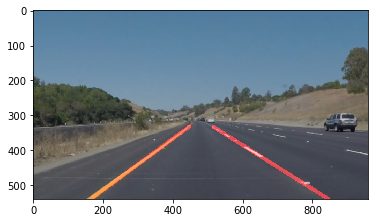

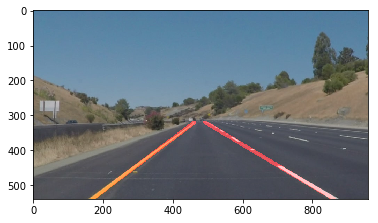

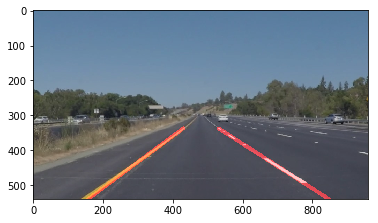

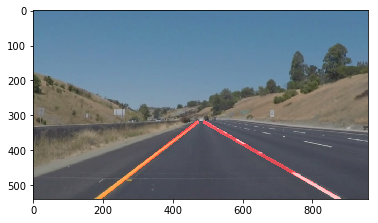

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
video = 0
for im in images:
    
    image = mpimg.imread("test_images/"+im)
    #print("test_images/"+im)

    #plt.figure()
    #plt.imshow(image)
    # Here we read a .png and convert to 0,255 bytescale
    gray = grayscale(image)
    #plt.figure()
    #plt.imshow(gray, cmap='gray')

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 9
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    # Next we'll create a masked edges image
    imshape = image.shape
    vertices = np.array([[(100,imshape[0]),(460, 320), (520, 320), (imshape[1]-50,imshape[0])]], dtype=np.int32)
    mask, masked_edges = region_of_interest(edges, vertices)
    
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 40     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 30 #minimum number of pixels making up a line
    max_line_gap = 15    # maximum gap in pixels between connectable line segments
    
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    # Draw lines on a blank image
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap, video)
    #plt.figure()
    #plt.imshow(masked_edges)
    # Draw the lines on the original image
    imageWithLines = cv2.addWeighted(image, 0.8, lines, 0.6, 0)
    #imageWithLines = cv2.addWeighted(masked_edges, 0.8, lines[:,:,0], 0.6, 0)
    
    plt.figure()
    plt.imshow(imageWithLines)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image,):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    gray = grayscale(image)
    #plt.imshow(image, cmap='gray')
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    # Next we'll create a masked edges image
    imshape = image.shape
    vertices = np.array([[(100,imshape[0]),(460, 320), (520, 320), (imshape[1]-50,imshape[0])]], dtype=np.int32)
    mask, masked_edges = region_of_interest(edges, vertices)
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 40     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 20 #minimum number of pixels making up a line
    max_line_gap = 15    # maximum gap in pixels between connectable line segments
    
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    # Draw lines on a blank image
    video = 1
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap, video)

    # Draw the lines on the initial image
    result = cv2.addWeighted(image, 0.8, lines, 0.6, 0) 
    #result2 = cv2.addWeighted(mask, 0.8, lines[:,:,0], 0.6, 0)
    #plt.figure()
    #plt.imshow(result2)
    return result

Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
fit_params = np.empty((1, 4))
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

OverflowError: cannot convert float infinity to integer

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
pos_slope = []
pos_intersect = []
neg_slope = []
neg_intersect = []
yellow_clip = clip2.fl_image(process_image).subclip(0,1)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

How could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

To improve lines detection, I removed outliers of slope detection of multiple segments and as second step in a video files if there is big change between slope and intersection detection in consequitive frames, for drawing lines in *n*-th frame, I have used fitting parameters from *n-1*-th frame. It works good for both video file.     
There are two potential problems with current detection:
1. If there will be a slow drift of fitting parameters in few consequitive frames, then my algorithm will misdetect fitting params in all following frames. To overcome this issue, in case of misdetection in *n*-th frame I could replace fitting parameters with average of parameters of last 10-20 frames. Even better, I cold replace with average of parameters of last 10-20 frames without outliers.
2. If camera would be positioned in different postion or car with start changing between lines, then current line will be out of ROI and won't be detected.


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))